In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import scipy.fft as fft
import scipy.signal as signal
from sklearn.pipeline import Pipeline
from pprint import pprint
from datetime import datetime
from scipy.signal import find_peaks
import pywt

C:\Users\loren\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Select file to analyze
filenames = ["../Data/center_sternum.txt", "../Data/1_Stave_supine_static.txt", "../Data/2_Mattress_supine.txt", 
             "../Data/3_Subject_sitting_chair.txt", "../Data/4_Chest_sweater.txt", "../Data/5_Under_chair.txt"]

chosen_file = 5

cuts = [(1129, 14306), (1750, 7999), (1659, 11078), (875, 6109), (1689, 5687), (834, 8756)]

## IMPORT DATA-SET AND CALIBRATION

In [3]:
# Import the file insicenter_sternumde "raw_data" Dataframe
data = pd.read_csv(filenames[chosen_file], sep='\t').reset_index(drop=True)
data

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555432196,8.357,-38.369,1028.094,-2.804878,1.585366,0.243902,-155,29,-227,0.780042,-0.008728,0.002716,-0.625660
1,5,100,1555432196,-368.928,-44.408,-853.329,30.121950,21.219510,26.219510,-267,134,624,0.390698,0.294320,0.869625,-0.066958
2,5,100,1555432196,-359.717,-52.216,-867.176,-2.804878,1.585366,-0.121951,-267,133,624,0.218179,0.311960,0.921964,-0.071139
3,5,100,1555432196,-372.771,-52.704,-873.215,-2.804878,1.707317,0.243902,-268,134,622,0.198960,0.313273,0.925840,-0.071383
4,5,100,1555432196,-370.209,-48.434,-852.841,-2.560976,1.585366,0.243902,-266,133,621,0.191172,0.313761,0.927305,-0.071505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,5,100,1555432909,-360.754,-48.678,-857.111,-3.414634,-0.487805,0.243902,-243,129,627,0.150588,0.537950,0.821619,-0.113468
9908,5,100,1555432909,-361.059,-54.778,-851.743,-3.048780,0.243902,-0.121951,-243,129,627,0.150335,0.538408,0.821345,-0.113620
9909,5,100,1555432909,-303.048,-53.009,-815.570,-2.682927,1.097561,0.243902,-243,130,628,0.165176,0.532487,0.822504,-0.112522
9910,5,100,1555432909,-369.233,-50.142,-860.344,-2.926829,0.365854,0.609756,-245,130,627,0.161020,0.537980,0.819636,-0.113346


In [4]:
#calibrate the dataset
def calibrate(data):
    
    offset_gyro = np.array([-2.242224, 2.963463, -0.718397])

    calibration_acc = np.array([[1.000966,     -0.002326418,-0.0006995499],
                                [-0.002326379,  0.9787045,  -0.001540918],
                                [-0.0006995811,-0.001540928, 1.00403]])
    offset_acc = np.array([-3.929942, -13.74679, 60.67546])

    calibration_magn = np.array([[0.9192851, -0.02325168, 0.003480837],
                                [-0.02325175, 0.914876, 0.004257396],
                                [0.003481006, 0.004257583, 0.8748001]])
    offset_magn = np.array([-95.67974, -244.9142, 17.71132])

    if filenames[chosen_file] != "../Data/center_sternum.txt":
        offset_gyro = np.array([-2.804399, 1.793105, 0.3411708])

        calibration_acc = np.array([[1.002982,    9.415505E-05, 0.004346743],
                                    [9.04459E-05, 1.002731,    -0.001444198],
                                    [0.004346536,-0.001444751,  1.030587]])
        offset_acc = np.array([3.602701, -20.96658, 54.97186])

        calibration_magn = np.array([[1.013437,    -0.04728858,  -0.001861475],
                                    [-0.04728862,  1.004832,    0.008222118],
                                    [-0.001861605, 0.008221965, 0.9439077]])
        offset_magn = np.array([-150.4098, 74.62431, 630.9805])

    # Apply calibration and offset to respective columns
    data[['GyroX', 'GyroY', 'GyroZ']] += offset_gyro
    data[['AccX', 'AccY', 'AccZ']] = np.dot(data[['AccX', 'AccY', 'AccZ']], calibration_acc.T) + offset_acc
    data[['MagnX', 'MagnY', 'MagnZ']] = np.dot(data[['MagnX', 'MagnY', 'MagnZ']], calibration_magn.T) + offset_magn

    return data

In [5]:
data = calibrate(data)

### SAMPLE RATE ANALYSIS

In [6]:
# Cofronting the nominal frequency given in the coloumn with the one we can get from timestamps
couts = data.groupby(["Log Freq"]).count().value_counts()
frequency = data.loc[0, "Log Freq"]
print("The nominal frequency in the Log column is", frequency)

t_min = datetime.fromtimestamp(data["Timestamp"].min())  
t_max = datetime.fromtimestamp(data["Timestamp"].max())  
acquisition_seconds = (t_max-t_min).total_seconds()      
acq_per_sec = data.groupby("Timestamp").size()
mean_frequency = np.mean(acq_per_sec)  


print("The starting time for the acquisition is: ", t_min)
print("The ending time for the acquisition is: ", t_max)
print("The total time of acquisition is: ", acquisition_seconds, "s")

print("\nThe total number of acquisitions is: ",data.shape[0])
print("The mean sampling frequency is: ", round(mean_frequency, 3))

percentage_difference = np.abs(frequency - mean_frequency) / frequency * 100
print("The difference in percentage from the nominal frequency to the mean frequency from time stamps is", round(percentage_difference, 2),"%")

The nominal frequency in the Log column is 100
The starting time for the acquisition is:  2019-04-16 18:29:56
The ending time for the acquisition is:  2019-04-16 18:41:49
The total time of acquisition is:  713.0 s

The total number of acquisitions is:  9912
The mean sampling frequency is:  100.121
The difference in percentage from the nominal frequency to the mean frequency from time stamps is 0.12 %


Since the difference in percentage from the nominal frequency and the one computed from timestamps we wonder if the frequency is actually constant during the acquisition.

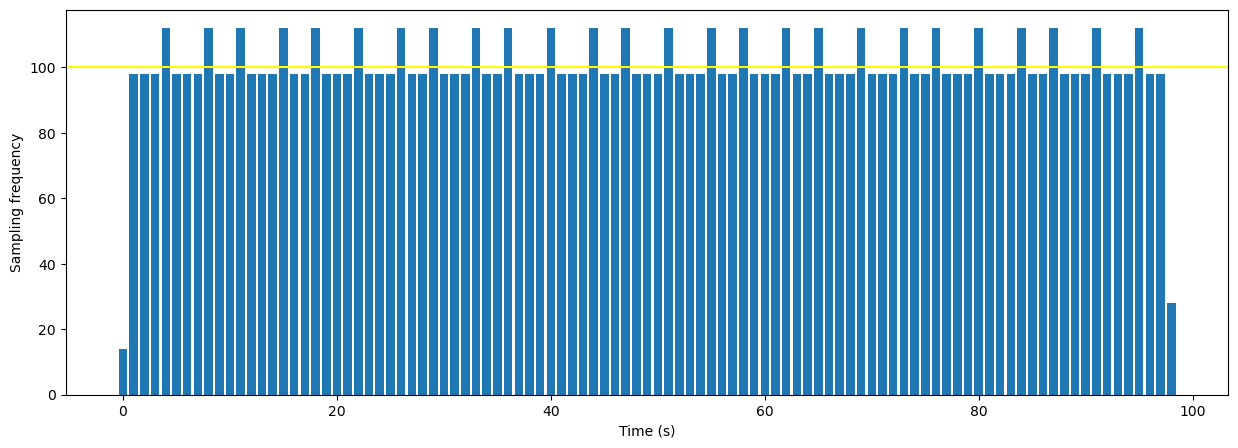

In [7]:
unique_timestamp_counts = data["Timestamp"].value_counts()
num_unique_timestamps = len(unique_timestamp_counts)

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(num_unique_timestamps), acq_per_sec)
ax.axhline(mean_frequency, color="red", label="Mean frequency")
ax.axhline(frequency, color="yellow", label="Nominal frequency")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Sampling frequency");

We see from te plot that the sampling frequency isn't the same on all seconds

In [8]:
# we also see that in total we have 16492 rows, so we insert a coloumn with time
data.insert(2, "Time", np.arange(0, data.shape[0]) * (1 / mean_frequency), allow_duplicates=False)

### PLOTTING THE DATA

In [9]:
# define the column groups
column_groups = {
    "Accelerometer": ["AccX", "AccY", "AccZ"],
    "Gyroscope": ["GyroX", "GyroY", "GyroZ"],
    "Magnetometer": ["MagnX", "MagnY", "MagnZ"],
    "Quaternion": ["qw", "qi", "qj", "qk"]
}


In [10]:
def plot(data, column_groups):
    """ Function to plot the data divided in sub-groups """
    # create subplots for each group
    fig, axs = plt.subplots(len(column_groups), 1, figsize=(15, 10), sharex=False)

    # iterate through column groups and plot all columns in the same graph for each group
    for i, (group_name, columns) in enumerate(column_groups.items()):
        data.plot(ax=axs[i], x="Time", y=columns, title=group_name)
        axs[i].set_ylabel(group_name)

    # set common x-axis label
    axs[-1].set_xlabel("Time")

    # adjust layout for better readability
    plt.tight_layout()




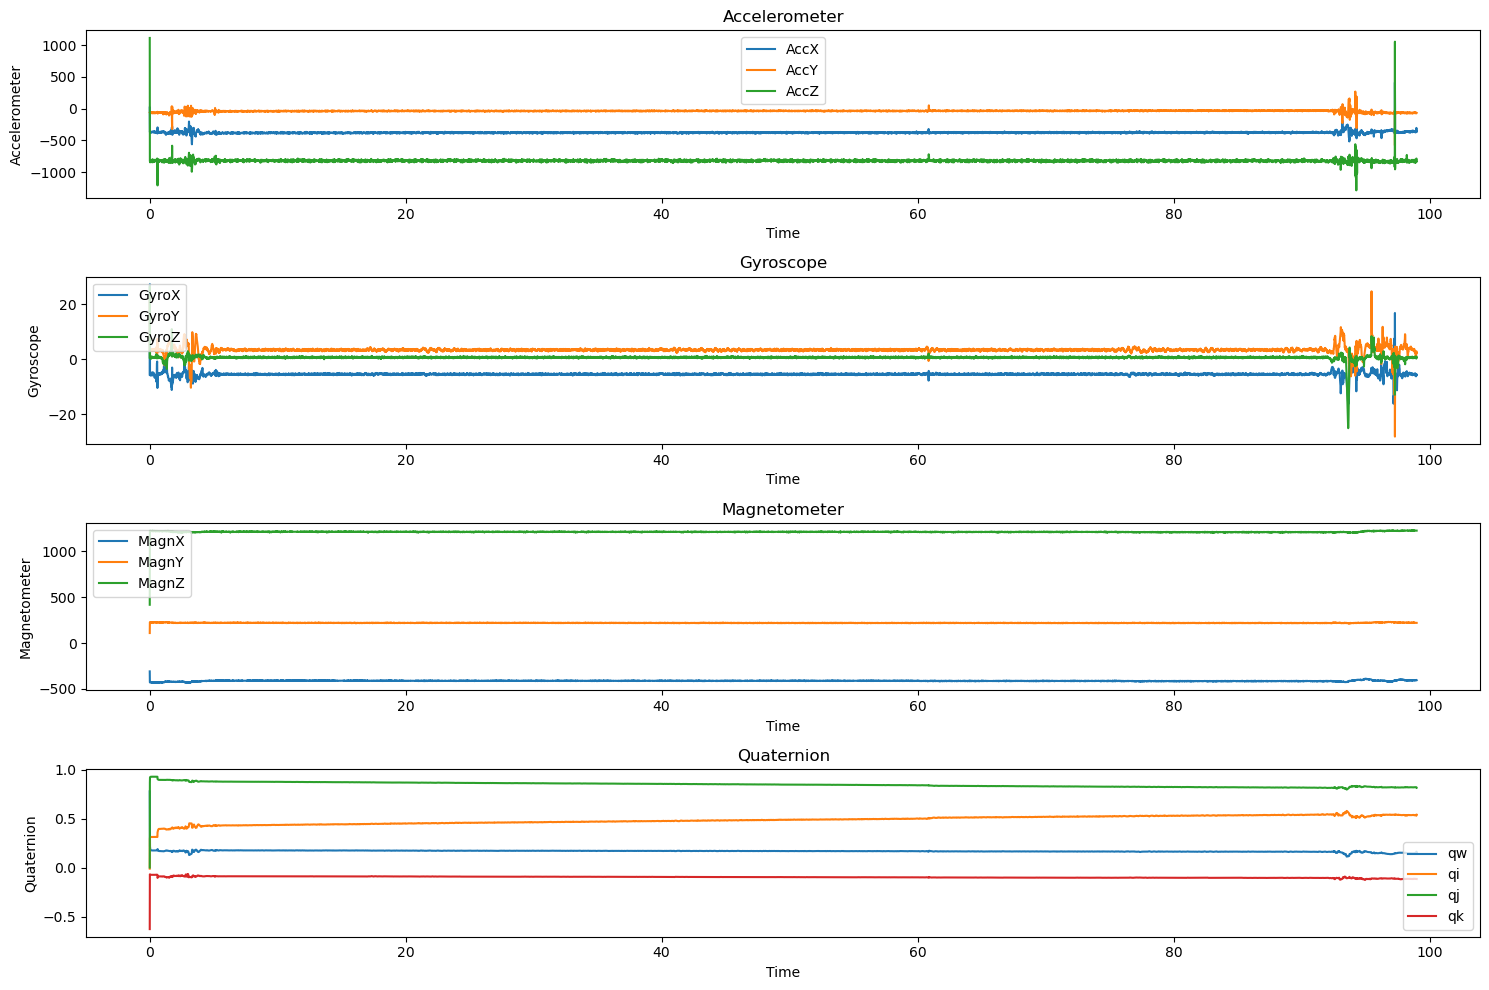

In [11]:
plot(data, column_groups)

We see that at the beginning and at the end of the data set there is a lot of noise, we need to clean the data-set: to do so we only the central rows of the data-frame, where the bounds of it are determined using a method called IQR 

### CLEANING THE DATA

In [12]:
# Cutting the start and the end of the dataset
cleaned_data = data[cuts[chosen_file][0]: cuts[chosen_file][1]].reset_index(drop=True)
cleaned_data.tail()

,Log Mode,Log Freq,Time,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
7917,5,100,87.404056,1555432897,-365.068153,-31.915287,-799.493176,-5.609277,3.256520,0.707024,-414.967670,219.281220,1210.169050,0.164917,0.537828,0.820338,-0.102908
7918,5,100,87.414044,1555432897,-375.132971,-36.412032,-821.281442,-5.487326,3.378471,0.463122,-412.838773,217.144090,1206.373252,0.164707,0.537828,0.820338,-0.103244
7919,5,100,87.424031,1555432897,-380.794761,-31.304070,-800.253722,-5.487326,3.012617,0.707024,-414.916659,218.259943,1208.273012,0.165051,0.537309,0.820612,-0.103214
7920,5,100,87.434019,1555432897,-371.186116,-37.217240,-813.845162,-5.487326,3.256520,0.707024,-413.814229,216.227657,1211.086430,0.164788,0.537797,0.820368,-0.103030
7921,5,100,87.444007,1555432897,-382.192454,-36.037827,-826.907518,-5.487326,3.256520,0.585073,-413.952372,219.225709,1209.223280,0.165053,0.537553,0.820490,-0.102908


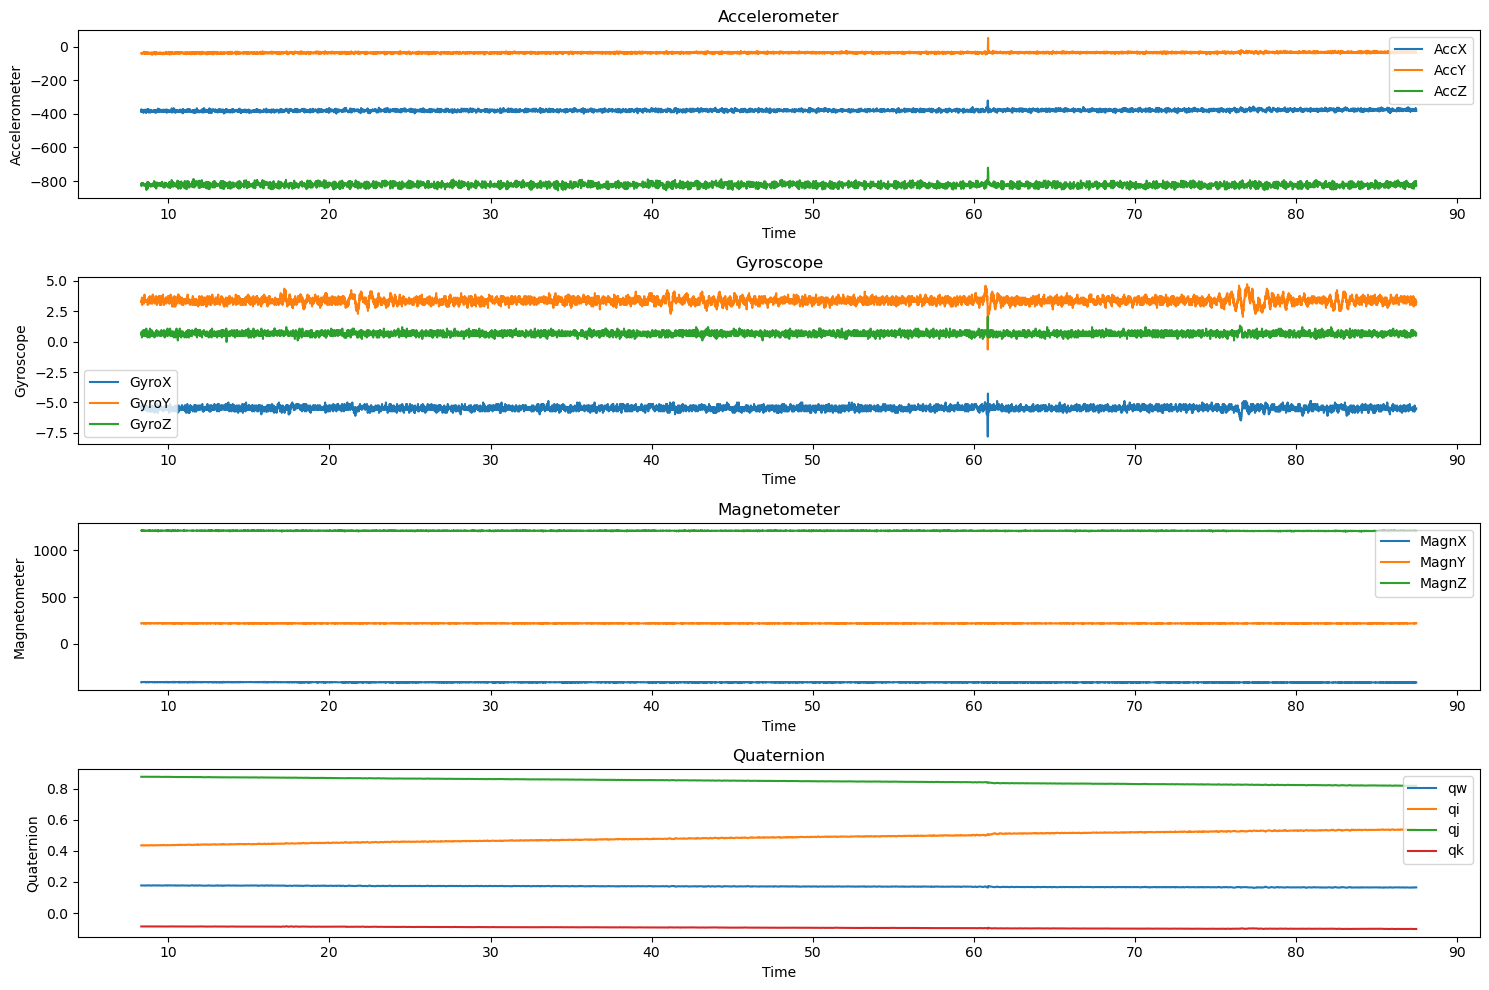

In [13]:
plot(cleaned_data, column_groups)


## PCA

In [14]:
## Pre-processing data: dropping columns and scaling
data_for_pca = cleaned_data.drop(columns=["Log Freq","Log Mode", "Time", "Timestamp"])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca)

In [15]:
## Instantiating PCA and kernelPCA
pca = PCA()

## Computing PCA
data_after_pca = pca.fit_transform(scaled_data)

PCA tell us to keep 7 features to retain 90% variance


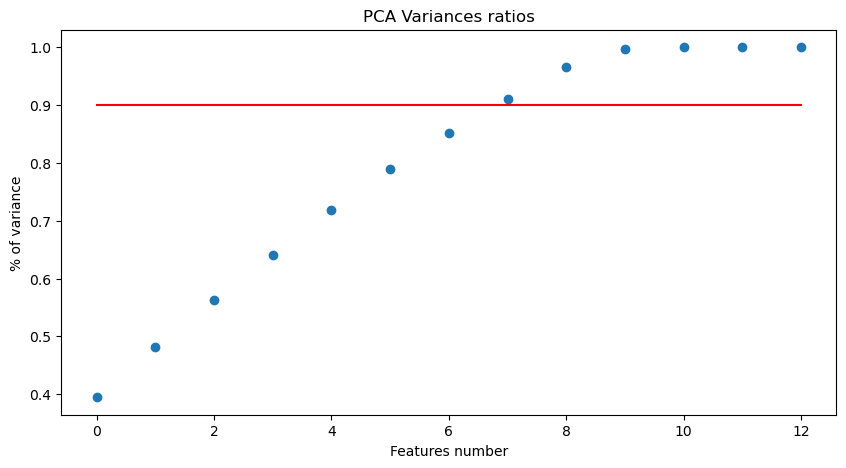

In [16]:
# Analyzing the result of PCA
PCA_Variances_Ratios = np.cumsum(pca.explained_variance_ratio_)

fig, ax1 = plt.subplots(1,1,figsize = (10,5))
ax1.scatter(np.arange(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
ax1.set_title("PCA Variances ratios")
ax1.set_ylabel("% of variance")
ax1.set_xlabel("Features number")
ax1.plot(np.arange(len(pca.explained_variance_ratio_)),np.ones(len(pca.explained_variance_ratio_))*0.9,color="red")
most_important_features_number = np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.9)
print(f"PCA tell us to keep {most_important_features_number} features to retain 90% variance")

C:\Users\loren\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


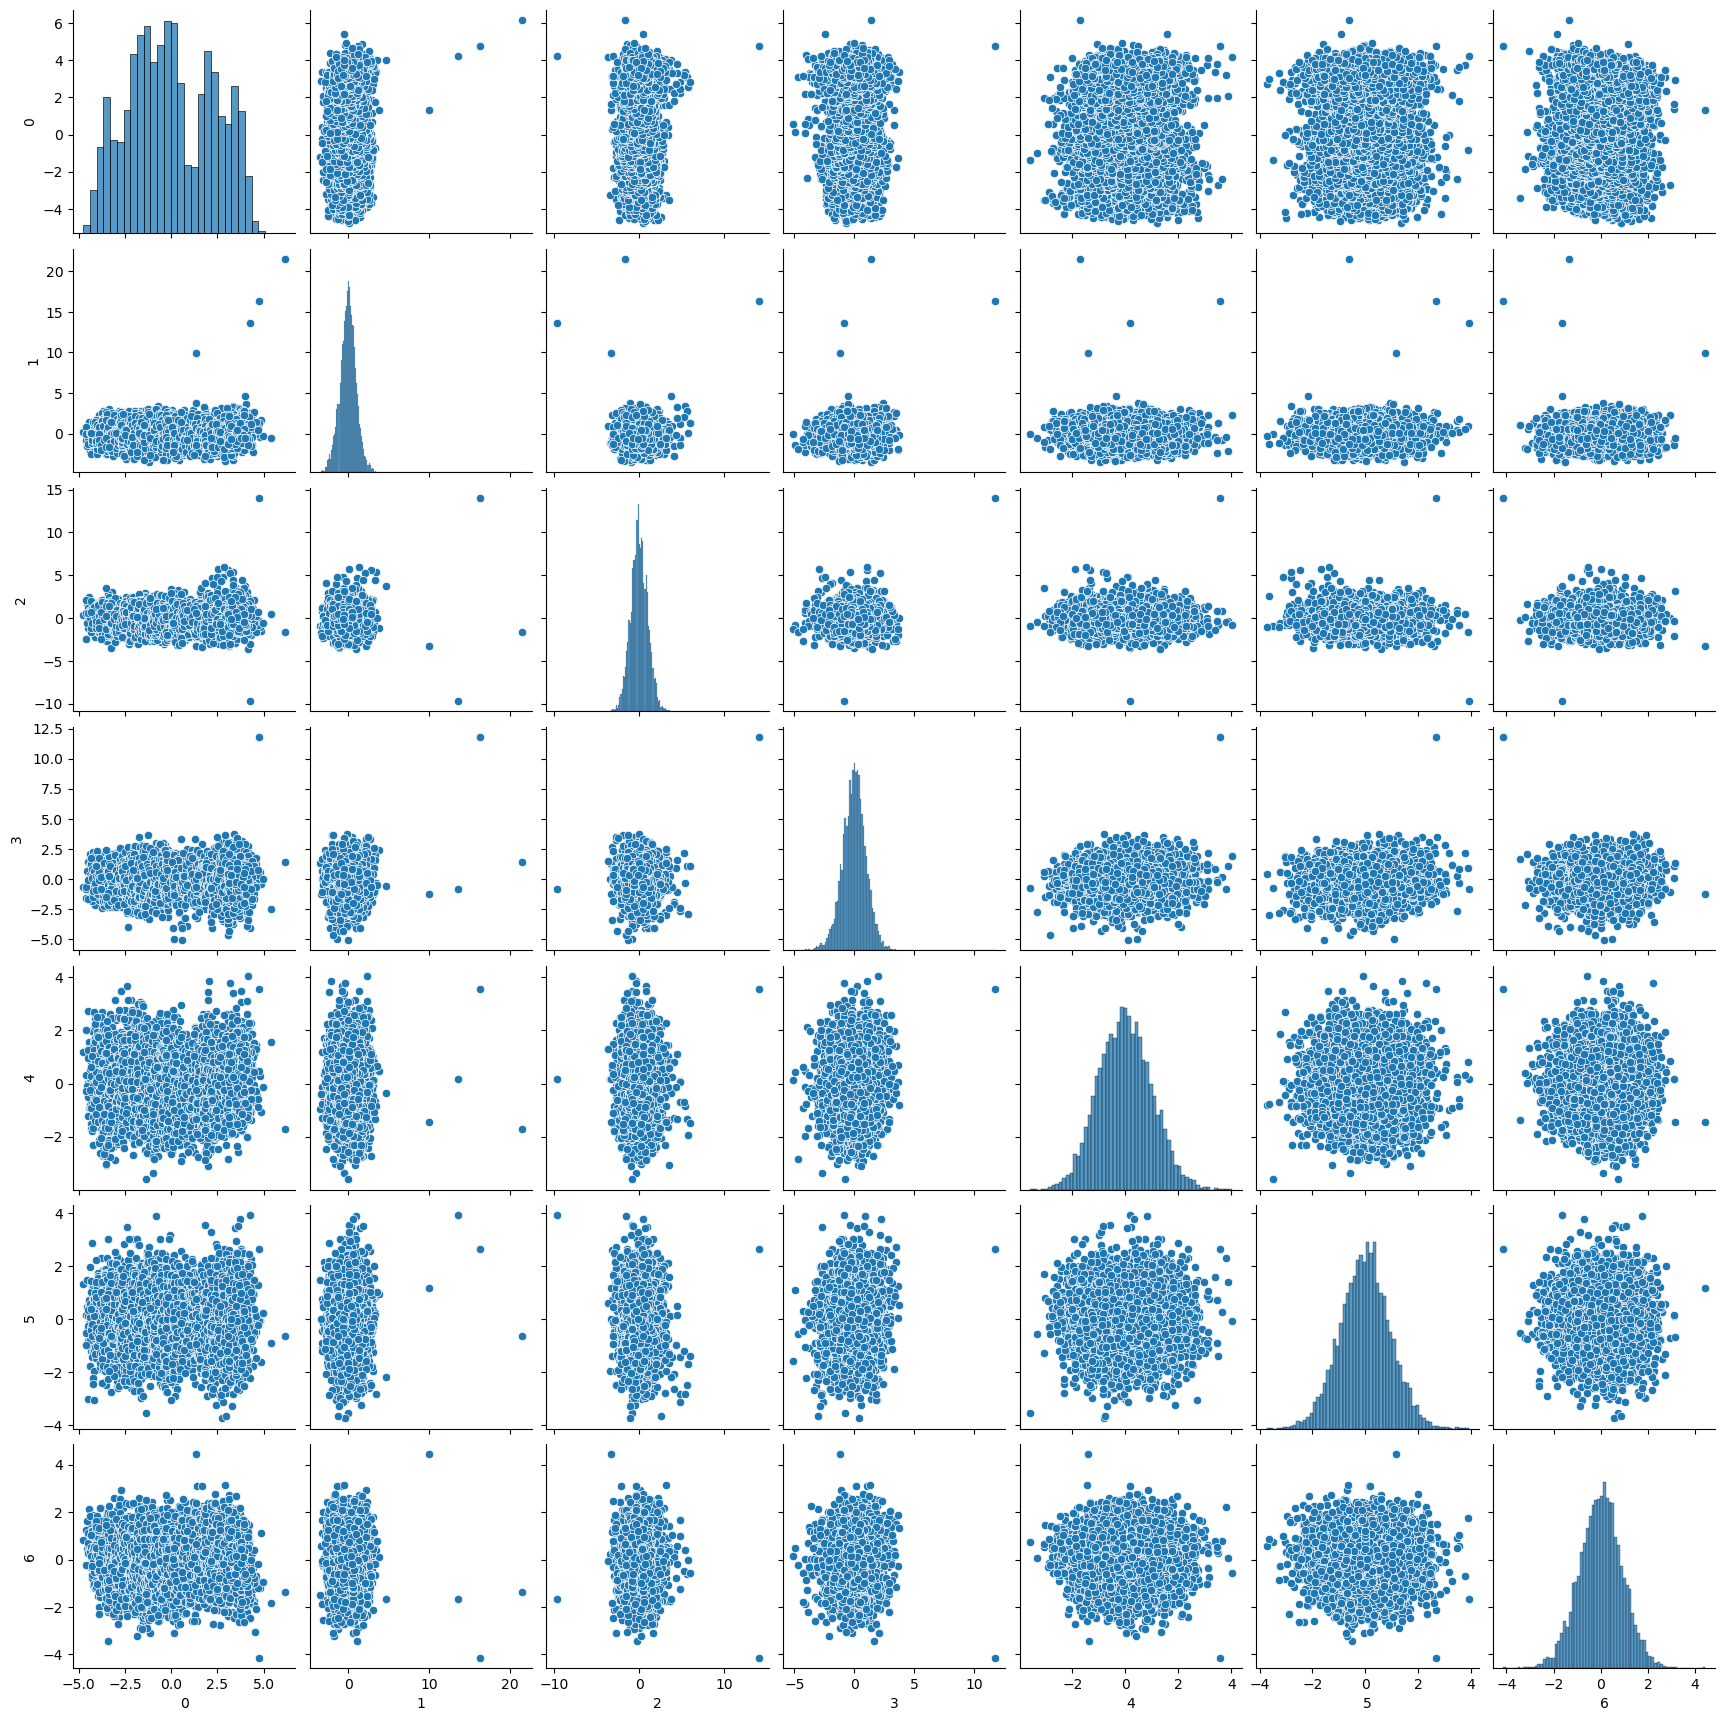

In [17]:
sns.pairplot(pd.DataFrame(data_after_pca[:,0:most_important_features_number]))

## Statistical Analysis

Here we want to obtain the main statistical information and heck the correlation among our data. 

In [18]:
column_names = []
for i in range(0, data_after_pca.shape[1]):
    column_names.append('Feature '+str(i))
data_after_pca_dataframe = pd.DataFrame(data_after_pca, columns=column_names)
description = data_after_pca_dataframe.describe()
description = pd.concat([description, pd.DataFrame(data_after_pca_dataframe.median(axis=0), columns=['median']).T])
description = pd.concat([description, pd.DataFrame(data_after_pca_dataframe.std(axis=0)**2, columns=['variance']).T])
print(description[column_names[0:5]])
print(description[column_names[5:10]])

             Feature 0    Feature 1     Feature 2     Feature 3     Feature 4
count     7.922000e+03  7922.000000  7.922000e+03  7.922000e+03  7.922000e+03
mean     -1.148062e-16     0.000000  1.076308e-17  2.152616e-17  2.511386e-17
std       2.265473e+00     1.063219  1.032229e+00  1.005421e+00  1.000408e+00
min      -4.757895e+00    -3.513865 -9.715814e+00 -5.088813e+00 -3.601739e+00
25%      -1.738131e+00    -0.647303 -6.731935e-01 -6.228571e-01 -7.002057e-01
50%      -1.871244e-01     0.001179 -3.788501e-02  2.383010e-02 -1.445144e-02
75%       1.972529e+00     0.634527  6.670994e-01  6.362154e-01  6.694016e-01
max       6.162575e+00    21.503757  1.400709e+01  1.179006e+01  4.024771e+00
median   -1.871244e-01     0.001179 -3.788501e-02  2.383010e-02 -1.445144e-02
variance  5.132368e+00     1.130435  1.065497e+00  1.010872e+00  1.000815e+00
             Feature 5     Feature 6     Feature 7     Feature 8     Feature 9
count     7.922000e+03  7.922000e+03  7.922000e+03  7.922000e+0

In [19]:
print(description[column_names[10:]])

            Feature 10    Feature 11    Feature 12
count     7.922000e+03  7.922000e+03  7.922000e+03
mean      4.664002e-17  3.767078e-17 -2.242309e-18
std       1.567374e-01  6.570829e-02  2.413218e-02
min      -9.486269e-01 -4.223373e-01 -8.727155e-02
25%      -9.349385e-02 -3.652340e-02 -1.945073e-02
50%       5.217518e-03  5.868366e-03 -3.847740e-03
75%       1.023353e-01  4.178373e-02  1.591602e-02
max       1.032122e+00  8.133574e-01  9.985005e-02
median    5.217518e-03  5.868366e-03 -3.847740e-03
variance  2.456660e-02  4.317580e-03  5.823621e-04


In [20]:
correlations = np.corrcoef(data_after_pca.T)
t = np.abs(correlations)*np.sqrt((len(data_after_pca_dataframe)-2)/(1-correlations**2))
for i in range(t.shape[0]):
    t[i,i]=0 
print(t[np.abs(t)>1e-3])

[]


C:\Users\loren\AppData\Local\Temp\ipykernel_16632\2363383155.py:2: RuntimeWarning: divide by zero encountered in divide
  t = np.abs(correlations)*np.sqrt((len(data_after_pca_dataframe)-2)/(1-correlations**2))


The data after PCA is very uncorrelated.

In [21]:
"""
res = stats.normaltest(kpca_data, axis=0)
print(res.pvalue)
vaz = kpca_data[:,5]
plt.hist(vaz, bins=(1+np.int(np.ceil(np.log2(vaz.shape[0])))))
plt.ylim(0,2000)
def gaussian(x, mu, sig):
    return 9346*0.1/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
plt.plot(np.linspace(-1,1),gaussian(np.linspace(-1,1),1.349469e-16, 1.729172e-01))"""

'\nres = stats.normaltest(kpca_data, axis=0)\nprint(res.pvalue)\nvaz = kpca_data[:,5]\nplt.hist(vaz, bins=(1+np.int(np.ceil(np.log2(vaz.shape[0])))))\nplt.ylim(0,2000)\ndef gaussian(x, mu, sig):\n    return 9346*0.1/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)\nplt.plot(np.linspace(-1,1),gaussian(np.linspace(-1,1),1.349469e-16, 1.729172e-01))'

## Discrete Fourier Transform

In [22]:
data_after_pca_only_most_important_feature = data_after_pca[:,0:most_important_features_number]
N = len(data_after_pca)

# Perform the DFT
sig_fft = fft.fftshift(fft.fft(data_after_pca_only_most_important_feature, axis=0))
frequencies = fft.fftshift(fft.fftfreq(N, d=1/mean_frequency))

AssertionError: Size error

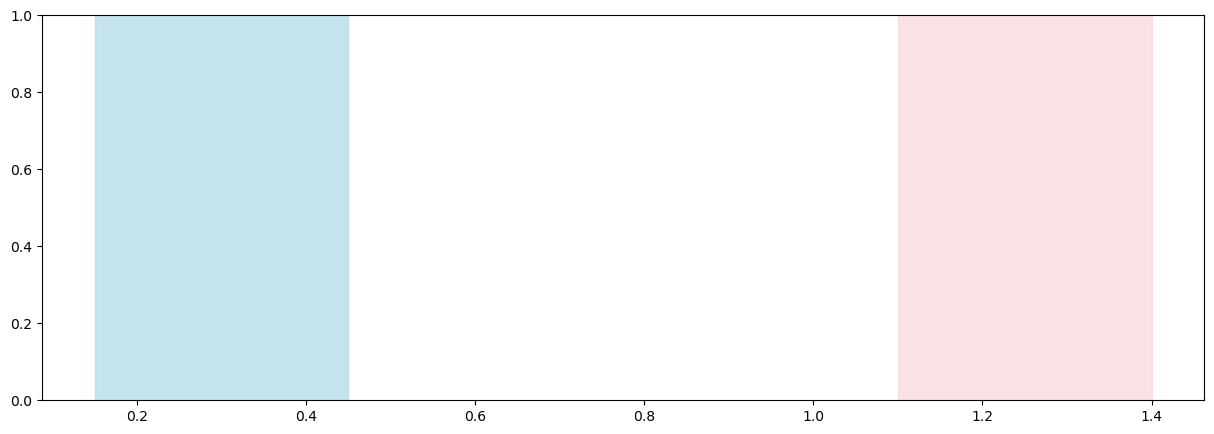

In [23]:
# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))

ax.axvspan(0.15, 0.45, color="lightblue", alpha=0.7, label="Breathing range")
ax.axvspan(1.1, 1.4, color="#F8D5D8", alpha=0.7, label="Heart rate range")

pca_indeces = np.arange(most_important_features_number)
palette = ['#66c2a5', '#fc8d62', '#8da0cb', 'blue', 'grey', 'grey']
palette = palette[0:most_important_features_number]
assert len(pca_indeces) == len(palette), "Size error"
for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.xaxis.set_ticks(np.arange(0, 10, 0.5))
ax.set_xlim(0, 5)
ax.set_ylim(-0.5, 3000)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average)", fontsize=20)
ax.legend(fontsize=15)
#ax.grid('lightgrey')


In [ ]:
# Plot relevant frequency band
fig, ax = plt.subplots(figsize=(15, 5))

pca_indeces = np.arange(most_important_features_number)
palette = ['#66c2a5', '#fc8d62', '#8da0cb', 'blue', 'grey', 'grey']
palette = palette[0:most_important_features_number]
assert len(pca_indeces) == len(palette), "Size error"
for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies, np.abs(sig_fft[:, i]), 3, color=color, label="PC"+str(i+1))

ax.set_xlim(1.0, 1.5)
ax.set_ylim(-0.5, 4000)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Heartbeat Frequency spectrum", fontsize=20)
#ax.grid('lightgrey')

## Filters

### Filter on the spectrum

In [ ]:
filtered_sig_fft = sig_fft.copy()
filtered_sig_fft[(np.abs(frequencies) < 1.1) | (np.abs(frequencies) > 1.4)] = 0

inversed_sig_fft = np.fft.ifft(np.fft.ifftshift(filtered_sig_fft), axis=0)

In [ ]:
# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))

pca_indeces = np.arange(most_important_features_number)
palette = ['#66c2a5', '#fc8d62', '#8da0cb', 'blue', 'grey', 'grey']
palette = palette[0:most_important_features_number]
assert len(pca_indeces) == len(palette), "Size error"
for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(filtered_sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.set_xlim(-5, 5)
ax.set_ylim(-0.5, 1600)
ax.xaxis.set_ticks(np.arange(-5, 5, 0.5))
ax.vlines(0, -0.5, 1600, color="black")
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average) after filter", fontsize=20)
ax.legend(fontsize=15)
#ax.grid('lightgrey')

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(inversed_sig_fft.real)
ax.set_title("Anti-transformed data after filter")
ax.set_ylabel("AU")
ax.set_xlabel("Time")
# inversed_sig_fft to absolout value

In [ ]:
peaks = []
periods = []
heights = []
for i in range(most_important_features_number):
    peak, properties = find_peaks(inversed_sig_fft[:, i].real)
    peaks.append(peak)
    heights.append(properties)

print(len(inversed_sig_fft[peaks[1]].real))
print(len(peaks[1]))

In [ ]:
fig, ax = plt.subplots(inversed_sig_fft.shape[1], 1, figsize=(20, 20))

for i in range(inversed_sig_fft.shape[1]):
    x_label = "PCA" + str(i + 1)
    ax[i].plot(inversed_sig_fft[:, i].real)
    ax[i].set_xlabel(x_label)
    ax[i].set_ylabel("AU")
    ax[i].scatter(peaks[i], inversed_sig_fft[peaks[i], i].real, marker="x", color="red")

In [ ]:
periods = []
for i in range(len(peaks)):
    difference = peaks[i][1:] - peaks[i][:-1]
    difference = mean_frequency/difference * 60
    periods.append(difference)

fig, ax = plt.subplots(6, 1, figsize=(15, 30))
for i in range (len(periods)):
    ax[i].hist(periods[i])

### Gaussian filter

In [ ]:
from scipy.optimize import curve_fit
gauss = lambda x, A, mu, sigma : A**2/sigma/np.sqrt(2*np.pi)*np.exp(-0.5*((x-mu)/sigma)**2)

In [ ]:
# Get the peaks
sig_peaks = sig_fft.copy()
sig_peaks[(frequencies < 1.2) | (frequencies > 1.3)] = 0

In [ ]:
# Fit the Gaussian
fits = [curve_fit(gauss, frequencies, sig_peaks[:, i].real, p0=[30, 1.25, 0.03]) for i in range(most_important_features_number)]
print("Amplitude: " + str([fits[i][0][0] for i in range(most_important_features_number)]))
print("Peaks: " + str([fits[i][0][1] for i in range(most_important_features_number)]))
print("Standard deviations: " + str([fits[i][0][2] for i in range(most_important_features_number)]))

In [ ]:
# Plot relevant frequency band
fig, ax = plt.subplots(figsize=(15, 5))

pca_indeces = np.arange(most_important_features_number)
palette = ['#66c2a5', '#fc8d62', '#8da0cb', 'blue', 'grey', 'grey']
palette = palette[0:most_important_features_number]
assert len(pca_indeces) == len(palette), "Size error"
for i, color in zip(pca_indeces, palette):
    #ax.plot(frequencies, np.abs(sig_peaks[:, i]), 3, color=color, label="PC"+str(i+1))
    ax.plot(frequencies, np.abs(sig_peaks[:, i]), 3, color=color)

lin = np.linspace(1.1, 1.4, 1000)
for i in range(most_important_features_number):
    ax.plot(lin, gauss(lin, fits[i][0][0], fits[i][0][1], fits[i][0][2]), lw=2, label="PCA " + str(i+1))
ax.legend(loc="upper right")

#ax.plot(lin, gauss(lin, fits[0][0][0], fits[0][0][1], fits[0][0][2]), lw=2, color="red")
#ax.plot(lin, gauss(lin, fits[1][0][0], fits[1][0][1], fits[1][0][2]), lw=2, color="b")
#ax.plot(lin, gauss(lin, fits[2][0][0], fits[2][0][1], fits[2][0][2]), lw=2, color="black")
#ax.plot(lin, gauss(lin, fits[3][0][0], fits[3][0][1], fits[3][0][2]), lw=2, color="orange")
#ax.plot(lin, gauss(lin, fits[4][0][0], fits[4][0][1], fits[4][0][2]), lw=2, color="purple")
#ax.plot(lin, gauss(lin, fits[5][0][0], fits[5][0][1], fits[5][0][2]), lw=2, color="violet")


ax.set_xlim(1.1, 1.4)
#ax.set_ylim(-0.5, 9000)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Heartbeat Frequency spectrum", fontsize=20)
#ax.grid('lightgrey')

In [ ]:
# Keep the gaussian referring to PCA 6
param = fits[5][0]

lin = np.linspace(0, 5, 100)
gaussian_spectrum = np.concatenate((gauss(lin, param[0], param[1], param[2]), gauss(-lin, param[0], -param[1], param[2])))
lin = np.concatenate((lin, -lin))
plt.plot(lin, gaussian_spectrum)

In [ ]:
inversed_sig_fft = np.fft.ifft(np.fft.ifftshift(gaussian_spectrum), axis=0)

plt.plot(inversed_sig_fft.real)

#### FILTER

* $f_s$ is the sample frequency
* The Daubechies 6 wavelet: smooth and pattern similar to ours  
* level (:= J) refers to the number of iterations of splitting into low and high frequency: len(coeffs) = J + 1
* The result of the wavedec is a list
    * The first element is approximation coefficients array (it refers to frequencies from 0 to $f_s/2^{J+1}$)
    * The others are the details coefficients  $cD_j \in \{cD_J, ..., cD_1\}$ arrays (the $j$-th coefficient refers to the frequencies from $f_s/2^{j+1}$ to $f_s/2^{j}$)


In [ ]:
# Perform the multilevel decomposition of the time series
max_level = pywt.dwt_max_level(len(data_after_pca_only_most_important_feature), "db6")
print("Maximum useful level of decomposition for this dataset: " + str(max_level))

coeffs = pywt.wavedec(data_after_pca_only_most_important_feature, "db6", level=max_level, axis=0)

In [ ]:
# Helper function to compute the frequency ranges of a wavelet decomposition
def get_frequency_ranges(f_s, level):
    freq = [[0, f_s/2**(level+1)]]

    for j in range(level, 0, -1):
        freq.append([f_s/2**(j+1), f_s/2**(j)])

    return freq

get_frequency_ranges(mean_frequency, max_level)

We expect the normal beat to be between $[0.67, 1.67] Hz$. The coefficient we need is the fifth (frequences between $[0.78, 1.56]Hz$). We are cutting some boundary frequences.  

In [ ]:
# Function to set to zero the unwanted coefficients
def select_coeffs(coeffs, useful_coeffs):
    assert type([0, 1]) == list, "useful_coeffs must be a list"

    for i in range(len(coeffs)):
        if i not in useful_coeffs:
            #Replace with a zero array of the same size
            coeffs[i] = np.zeros_like(coeffs[i])
    
    return coeffs

filtered_coeff = select_coeffs(coeffs, [4])

In [ ]:
filtered_sig = pywt.waverec(filtered_coeff, "db6", axis=0)

In [ ]:

plt.plot(filtered_sig[:1000])
print(filtered_sig.shape)

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(np.sum(filtered_sig, axis=1))

In [ ]:

peaks_wavelet = []
periods_wavelet = []
heights_wavelet = []
for i in range(most_important_features_number):
    peak, properties = find_peaks(filtered_sig[:, i].real)
    peaks_wavelet.append(peak)
    heights_wavelet.append(properties)


In [ ]:
fig, ax = plt.subplots(most_important_features_number, 1, figsize=(20, 20))

for i in range(0,filtered_sig.shape[1]):
    x_label = "PCA" + str(i + 1)
    ax[i].plot(filtered_sig[:, i].real)
    ax[i].set_xlabel(x_label)
    ax[i].set_ylabel("AU")
    ax[i].scatter(peaks_wavelet[i], filtered_sig[peaks_wavelet[i], i].real, marker="x", color="red")

In [ ]:
periods_wavelet = []
std_periods = []
mean_periods = []
periods_wavelet_after_rejetion = []

for i in range(len(peaks)):
    difference_wavelet = peaks_wavelet[i][1:] - peaks_wavelet[i][:-1]
    difference_wavelet = mean_frequency/difference_wavelet * 60
    periods_wavelet.append(difference_wavelet)
    std_period = np.std(periods_wavelet[i], axis=0)
    mean_period = np.mean(periods_wavelet[i], axis=0)
    std_periods.append(std_period)
    mean_periods.append(mean_period)
# std periods is a list of the standard deviations of the periods for each PCA, i thought we could use a multiple of this to filter peaks too near each other

fig, ax = plt.subplots(6, 1, figsize=(15, 30))
for i in range (len(periods_wavelet)):
    ax[i].hist(periods_wavelet[i], bins=int(np.sqrt(len(periods_wavelet[i]))) * 10)
    print(f"The median BPM for PCA {str(i+1)} is: ", np.median(periods_wavelet[i]))
    print(f"The mean BPM for PCA {str(i + 1)} is:",  mean_periods[i])
    print(f"The std BPM for PCA {str(i + 1)} is:",  std_periods[i])
    #print("He is dead WTF")
    ax[i].set_xlim(40, 100)


In [ ]:
indexes_to_delete = [3, 11, 18, 27, 32, 40, 43, 46, 48, 55, 64, -6]
filtered_sig_deleted=np.delete(filtered_sig[peaks_wavelet[0], 0],indexes_to_delete)
peaks_wavelet_delete=np.delete(peaks_wavelet[0],indexes_to_delete)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20, 10))

ax1.plot(filtered_sig[:, 0].real)
ax1.set_xlabel("Original PCA1")
ax1.set_ylabel("AU")
ax1.scatter(peaks_wavelet[0], filtered_sig[peaks_wavelet[0], 0].real, marker="x", color="red")
ax2.plot(filtered_sig[:, 0].real)
ax2.set_xlabel("Cleaned PCA1")
ax2.set_ylabel("AU")
ax2.scatter(peaks_wavelet_delete, filtered_sig_deleted.real, marker="x", color="red")

In [ ]:
difference_wavelet = peaks_wavelet_delete[1:] - peaks_wavelet_delete[:-1]
difference_wavelet = mean_frequency/difference_wavelet * 60
period_wavelet_delete = difference_wavelet
std_period_delete = period_wavelet_delete.std()
mean_period_delete = period_wavelet_delete.mean()
median_period_delete = np.median(period_wavelet_delete)
period_wavelet_delete_after_rejection=period_wavelet_delete[period_wavelet_delete-median_period_delete<std_period_delete]# this is 3 sigma rejection
std_period_delete_after_rejection = period_wavelet_delete_after_rejection.std()
median_period_delete_after_rejection = np.median(period_wavelet_delete_after_rejection)

print(f"The median BPM for original PCA 1 is:", np.median(periods_wavelet[0]))
print(f"The mean BPM for original PCA 1 is:",  mean_periods[0])
print(f"The std BPM for original PCA 1 is:",  std_periods[0])

print(f"The median BPM for cleaned PCA 1 is: ", median_period_delete)
print(f"The mean BPM for cleaned PCA 1 is:",  mean_period_delete)
print(f"The std BPM for cleaned PCA 1 is:",  std_period_delete)

print("Compatibility among medians is", (np.median(periods_wavelet[0])-median_period_delete)
                                        / np.sqrt(std_period_delete**2+std_periods[0]**2))
print("Compatibility among means is", (mean_periods[0]-mean_period_delete)
                                        / np.sqrt(std_period_delete**2+std_periods[0]**2))

We can see that the algorithm used for peak detection isn't perfect and some of the indices returned are not correct. Even with this though, the variance is still to big, because of unrealistic frequencies coming from the previous algorithm that are too big.

In [ ]:
# Integrate the information about all the principal components
total_periods = np.concatenate(periods_wavelet)

total_periods_after_rejection = total_periods[np.abs(total_periods-
                                                     median_period_delete_after_rejection)<std_period_delete_after_rejection]
restricted_total_periods = total_periods_after_rejection

hist_heights, edges = np.histogram(restricted_total_periods, 30)
bin_centers = 0.5*(edges[:-1]+edges[1:])

gaussian_fit, gaussian_fit_errors = curve_fit(gauss, bin_centers, hist_heights,
                         p0=[30, median_period_delete_after_rejection, std_period_delete_after_rejection])
A, mu, sigma = gaussian_fit

fig, ax = plt.subplots(figsize=(15, 5))
x = np.linspace(60,85)
ax.plot(x,A**2/sigma/np.sqrt(2*np.pi)*np.exp(-0.5*((x-mu)/sigma)**2))
ax.hist(total_periods[total_periods < 150], bins=80)
ax.hist(restricted_total_periods, bins=30)
ax.set_xlim(60, 80)

bpm_estimated_gaussian_fit = mu
bpm_std_estimated_gaussian_fit = gaussian_fit_errors[1,1]

print("The estimated BPM is", bpm_estimated_gaussian_fit, "+-", bpm_std_estimated_gaussian_fit)